In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
import matplotlib as mpl
#from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import time
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

In [2]:
with open('train_smt.pickle', 'rb') as f:
    X_train_smt, y_train_smt = pickle.load(f)
    
with open('test_smt.pickle', 'rb') as f:
    X_test_smt, y_test_smt = pickle.load(f) 
    
with open('test.pickle', 'rb') as f:
    stp_test_X, stp_test_y = pickle.load(f) 

with open('stp_features_names.pickle', 'rb') as f:
    stp_features_names = pickle.load(f) 

In [3]:
features_names=stp_features_names[0]
features_names

['Hypertension_1',
 'Heart_Disease_1',
 'Gender_Male',
 'Ever_Married_Yes',
 'Type_Of_Work_Never_worked',
 'Type_Of_Work_Private',
 'Type_Of_Work_Self-employed',
 'Type_Of_Work_children',
 'Residence_Urban',
 'Smoking_Status_never smoked',
 'Smoking_Status_smokes',
 'Smoking_Status_unknown',
 'Age',
 'Avg_Glucose',
 'BMI']

In [4]:
X_train_smt = pd.DataFrame.from_records(X_train_smt, columns=features_names)

In [5]:
X_train_smt.head(3)

,Hypertension_1,Heart_Disease_1,Gender_Male,Ever_Married_Yes,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Smoking_Status_unknown,Age,Avg_Glucose,BMI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.850470,-0.794488,-1.832740
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.481418,-0.355295,-0.384863
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.034127,-1.033074,0.306466


### 0. Definition, Understanding of the Problem and Approach

** Definition**
    - TP: True Positive (predict Stroke, there is a Stroke) also called "Save Life" in Presentation
    - TN: True Negative (predict no Stroke, there is no Stroke), also called "Save Time" in Presentation
    - FP: False Positive (predict Stroke, there is no Stroke), also called "False Alarm" in Presentation
    - FN: False Negative (predict No Stroke, there is a Stroke), also called "Missed Stroke" in Presentation

**Understanding of the problem**
- First we are concerned about maximizing RECALL (DETECTION in our PRESENTATION) = (TP/(TP+FN)): indeed, we want to minimize FN to save Lives.
- Second, we are concerned about keeping False Positive Rate (FPR) small = FP / (TN+FP)
    - Indeed, there is an economic cost of predicting too many FP

**Approach**
- In order to find the optimal RECALL/FPR we will compare our models using the ROC curve
- We will generate prediction probabilities for one class or another based on a picked threshold p =0.5
- We will initially compare the models without tuning for that threshold
- Then we will tune the best model to see if we can improve the performance further
    - We can then optimize the threshold for maximizing RECALL, minimizing FPR
    - We can also optimize the best model by tuning its parameters


## 1. Compare the performance of non tuned ML algorithm on our prepared dataset

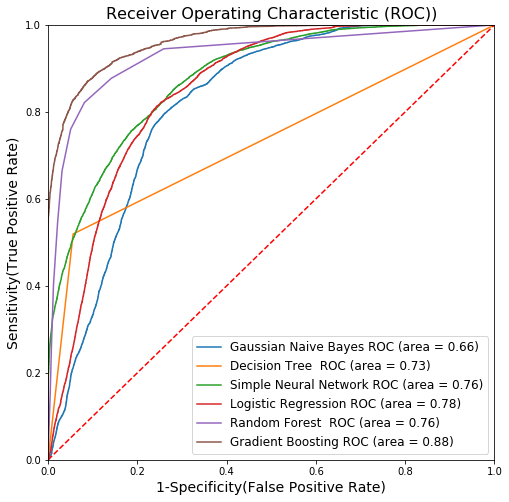

Execution time: 47.16381525993347 ms


In [6]:
start_time = time.time()

plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
    
    
{
    'label': 'Gaussian Naive Bayes',
    'model': GaussianNB(),
},
    
{
    'label': 'Decision Tree ',
    'model': DecisionTreeClassifier(),
},   

{
    'label': 'Simple Neural Network',
    'model': MLPClassifier(),
},
  
    
    
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
    
   
 
    
{
    'label': 'Random Forest ',
    'model': RandomForestClassifier(),
},  
 
     
    
#{
 #   'label': 'Support Vector Machine',   
  #  'model': SVC(),
#},   
    
    
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
    
 
    
]



# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_smt, y_train_smt) # train the model
    y_pred=model.predict(X_test_smt) # predict the test data
# Compute False postive rate, and True positive rate
    #if model==SVC():
     #   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.decision_function(X_test_smt)[:,1])
      #  model.probability = True
    #else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1])
    
# Calculate Area under the curve to display on the plot
    #if model==SVC():
     #   auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
      #  model.probability = True
    #else:
    auc = metrics.roc_auc_score(y_test_smt,y_pred)
    #auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=14)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC))', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

## 2. Tuning of the best model  

### 2.1 Gradient Boosting without modifying threshold and without tuning (baseline)

Accuracy of the GBM on test set: 0.852
             precision    recall  f1-score   support

          0       0.88      0.82      0.85     12755
          1       0.83      0.89      0.86     12755

avg / total       0.85      0.85      0.85     25510



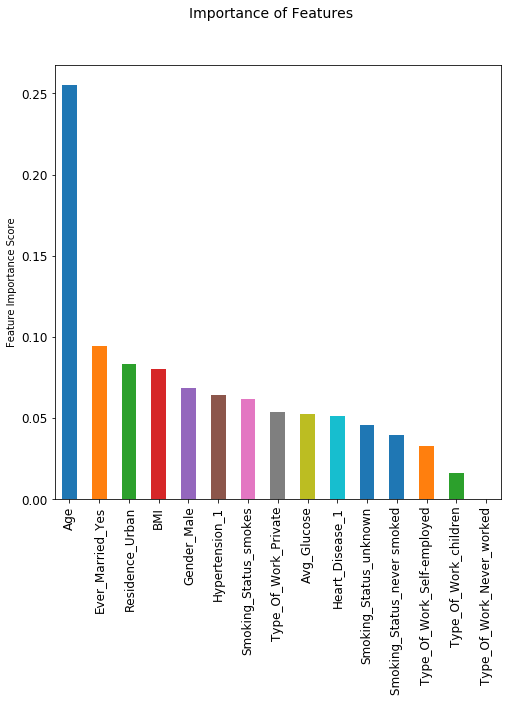

Execution time: 2.2210586071014404 ms


In [7]:
start_time = time.time()
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train_smt,y_train_smt)
predictors=list(X_train_smt)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.suptitle('Importance of Features', fontsize=14)
feat_imp.plot(kind='bar', fontsize=12)
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test_smt, y_test_smt)))
pred=baseline.predict(X_test_smt)
print(classification_report(y_test_smt, pred))
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [70]:
meu.display_model_performance_metrics(true_labels=y_test_smt,
    predicted_labels=pred, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.8519
Precision: 0.8536
Recall: 0.8519
F1 Score: 0.8517

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.88      0.82      0.85     12755
          1       0.83      0.89      0.86     12755

avg / total       0.85      0.85      0.85     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0      10426   2329
        1       1449  11306


### 2.2 Gradient Boosting with tuning**

#note: source of the code: article from Medium.
#https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

**2.3.1 Optimization of the learning rate** 
- We shrink the contribution of each tree by the learning_rate.

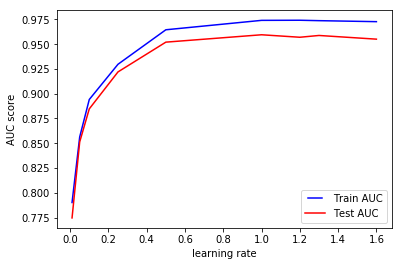

Execution time: 52.2571907043457 ms


In [9]:
start_time = time.time()
learning_rates = [1.6, 1.3, 1.2, 1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])  
   #roc_auc = auc(fpr, tpr)
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   #roc_auc = auc(fpr, tpr)
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, color='blue', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')


**Conclusion**
- For this data, a learning rate of 1.0 is optimal. 

** 2.3.2 N_estimators optimization** (note: this takes some time...)

- n_estimators represents the number of trees in the forest. 
- Usually, more trees = better learning, but it can slow the training and result in overfitting.
- We do a parameter search to find the sweet spot. 

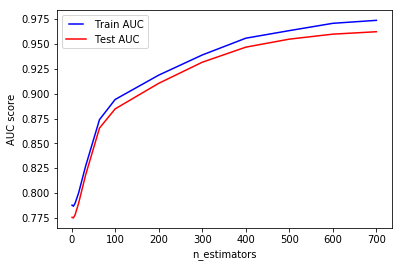

Execution time: 162.30986309051514 ms


In [10]:
start_time = time.time()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600, 700]

train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, color='blue', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')


**Conclusion**
- It looks like 600 trees is close to an optimum. Seems like a lot...

** 2.3.3 Optimization of the depth of the tree** (note: this training takes circa 12 minutes)

- max_depth indicates how deep the built tree can be. 
- The deeper the tree, the more splits it has and it captures more information about how the data.

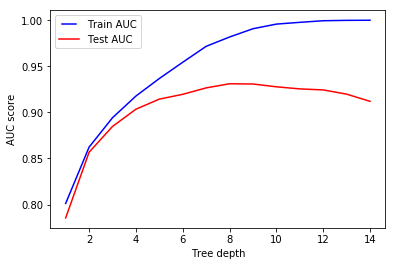

Execution time: 712.1621446609497 ms


In [16]:
start_time = time.time()
max_depths = np.linspace(1, 14, 14, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

**Conclusion**
- It looks like 8 trees depth is close to an optimum. 

** 2.3.3 Optimization of the min_samples_split** 

- Here we try to optimize the minimum number of samples required to split an internal node.
- The higher this number, the more constraint for the model to split
- Here we vary from minimum 1% to minimum 25%

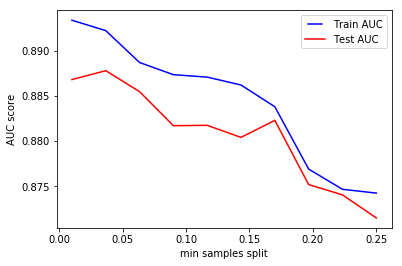

Execution time: 54.41342258453369 ms


In [13]:
start_time = time.time()
min_samples_splits = np.linspace(0.01, 0.25, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)
   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(min_samples_splits, train_results, color='blue', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

**Conclusion**
- 4% seems optimal parameter

 ** 2.3.4 Optimization of the min_samples_leaf **

- Min_samples_leaf is The minimum number of samples required to be at a leaf node at the end of the tree.
- Similar to the above

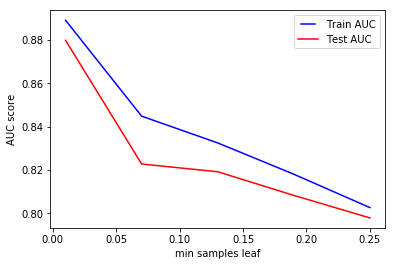

Execution time: 22.466903924942017 ms


In [15]:
start_time = time.time()
min_samples_leafs = np.linspace(0.01, 0.25, 5, endpoint=True)

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, color='blue', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

**Conclusion**
- We should not enter any parameters. We are overfitting.

 ** 2.3.5 Optimization of the max_features**

- represents the number of features to consider when looking for the best split.

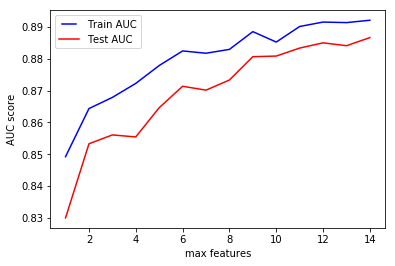

Execution time: 50.505908489227295 ms


In [19]:
start_time = time.time()
max_features = list(range(1,X_train_smt.shape[1]))

train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train_smt, y_train_smt)

   train_pred = model.predict(X_train_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, model.predict_proba(X_train_smt)[:,1])
   roc_auc = metrics.roc_auc_score(y_train_smt,train_pred)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test_smt)

   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1]) 
   roc_auc = metrics.roc_auc_score(y_test_smt,y_pred )
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(max_features, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_features, test_results, color='red', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()
print("Execution time: " + str((time.time() - start_time)) + ' ms')

**Conclusion**
- It looks like the model does not overfit. 
- 12 features is probably close to optimum

 ** 2.3.6 Putting all the optimization together and comparing with baseline**

In [ ]:
- We optimize for learning_rate, n_estimators, min_samples_split 
- We do not optimize for tree depth, as this is taking too much time (need a GPU/more CPU)
- We do not optimize for min_samples_leaf 

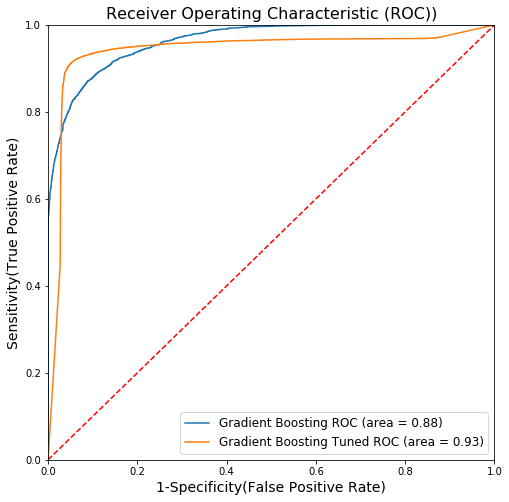

Execution time: 58.813687801361084 ms


In [25]:
start_time = time.time()

plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
    
     
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},  
    
    
{
    'label': 'Gradient Boosting Tuned',
    'model': GradientBoostingClassifier(learning_rate=1.0,n_estimators=600,
            min_samples_split=0.04, max_features=12, max_depth=8, random_state=10),
}
    
 
    
]



# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_smt, y_train_smt) # train the model
    y_pred=model.predict(X_test_smt) # predict the test data
# Compute False postive rate, and True positive rate
    #if model==SVC():
     #   fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.decision_function(X_test_smt)[:,1])
      #  model.probability = True
    #else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test_smt, model.predict_proba(X_test_smt)[:,1])
    
# Calculate Area under the curve to display on the plot
    #if model==SVC():
     #   auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
      #  model.probability = True
    #else:
    auc = metrics.roc_auc_score(y_test_smt,y_pred)
    #auc = metrics.roc_auc_score(y_test_smt,model.predict(X_test_smt))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=14)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC))', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Accuracy of the tuned GBM on test set: 0.930
             precision    recall  f1-score   support

          0       0.92      0.95      0.93     12755
          1       0.95      0.91      0.93     12755

avg / total       0.93      0.93      0.93     25510



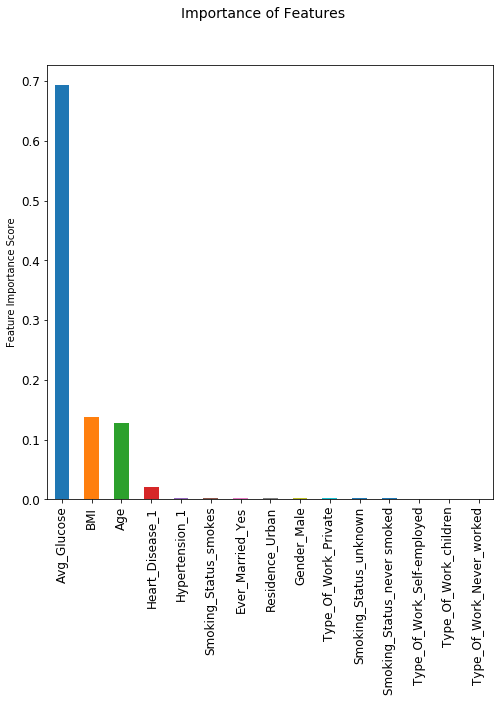

Execution time: 58.09461307525635 ms


In [26]:
start_time = time.time()
tuned = GradientBoostingClassifier(learning_rate=1.0,n_estimators=600,min_samples_split=0.04, max_depth=8 , max_features=12, random_state=10)



tuned.fit(X_train_smt,y_train_smt)
predictors=list(X_train_smt)
feat_imp = pd.Series(tuned.feature_importances_, predictors).sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.suptitle('Importance of Features', fontsize=14)
feat_imp.plot(kind='bar', fontsize=12)
plt.ylabel('Feature Importance Score')
print('Accuracy of the tuned GBM on test set: {:.3f}'.format(tuned.score(X_test_smt, y_test_smt)))
pred=tuned.predict(X_test_smt)
print(classification_report(y_test_smt, pred))
plt.show()   # Display
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [30]:
meu.display_model_performance_metrics(true_labels=y_test_smt,
    predicted_labels=pred, classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.9302
Precision: 0.9307
Recall: 0.9302
F1 Score: 0.9302

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.92      0.95      0.93     12755
          1       0.95      0.91      0.93     12755

avg / total       0.93      0.93      0.93     25510


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   0      1
Actual: 0      12087    668
        1       1112  11643


### 3. Features explanability using Lime and Shape (no time, needs to be done as a next step)

### 4. Appendix